# Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Open the files

In [2]:
file_path_d = '/Volumes/TOSHIBA/4t/Advanced Bioinformatics/Project/Python/scaled_data.csv'
file_path_c = '/Volumes/TOSHIBA/4t/Advanced Bioinformatics/Project/Python/cluster_labs.csv'

df = pd.read_csv(file_path_d, index_col = 0)
clust = pd.read_csv(file_path_c, index_col = 0)

# Classification using Random Forest

To classify samples of lung cancer patients based on its transcriptomic profile (the 4 clusters found), Random Forest algorithm will be used.
As a first step, the array will be generated and data will be split into the training and testing sets.

In [3]:
t_df = df.transpose()
X = t_df.to_numpy()
y = clust['x'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

Next, the Random Forest classifier will be created and trained on the training set.

In [4]:
clf = RandomForestClassifier(random_state = 43)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=43)

Afer training, predictions can be done on the test dataset. 

In [5]:
y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)

# Visualizing the Decision tree

The random forest algorithm we trained created 100 trees for the classification, so instead of choosing one, we will create an instance of Decision Tree classifier, and thain it for visualizing a tree.

Text(0.5, 1.0, 'Decision tree trained on all the lung cancer samples features')

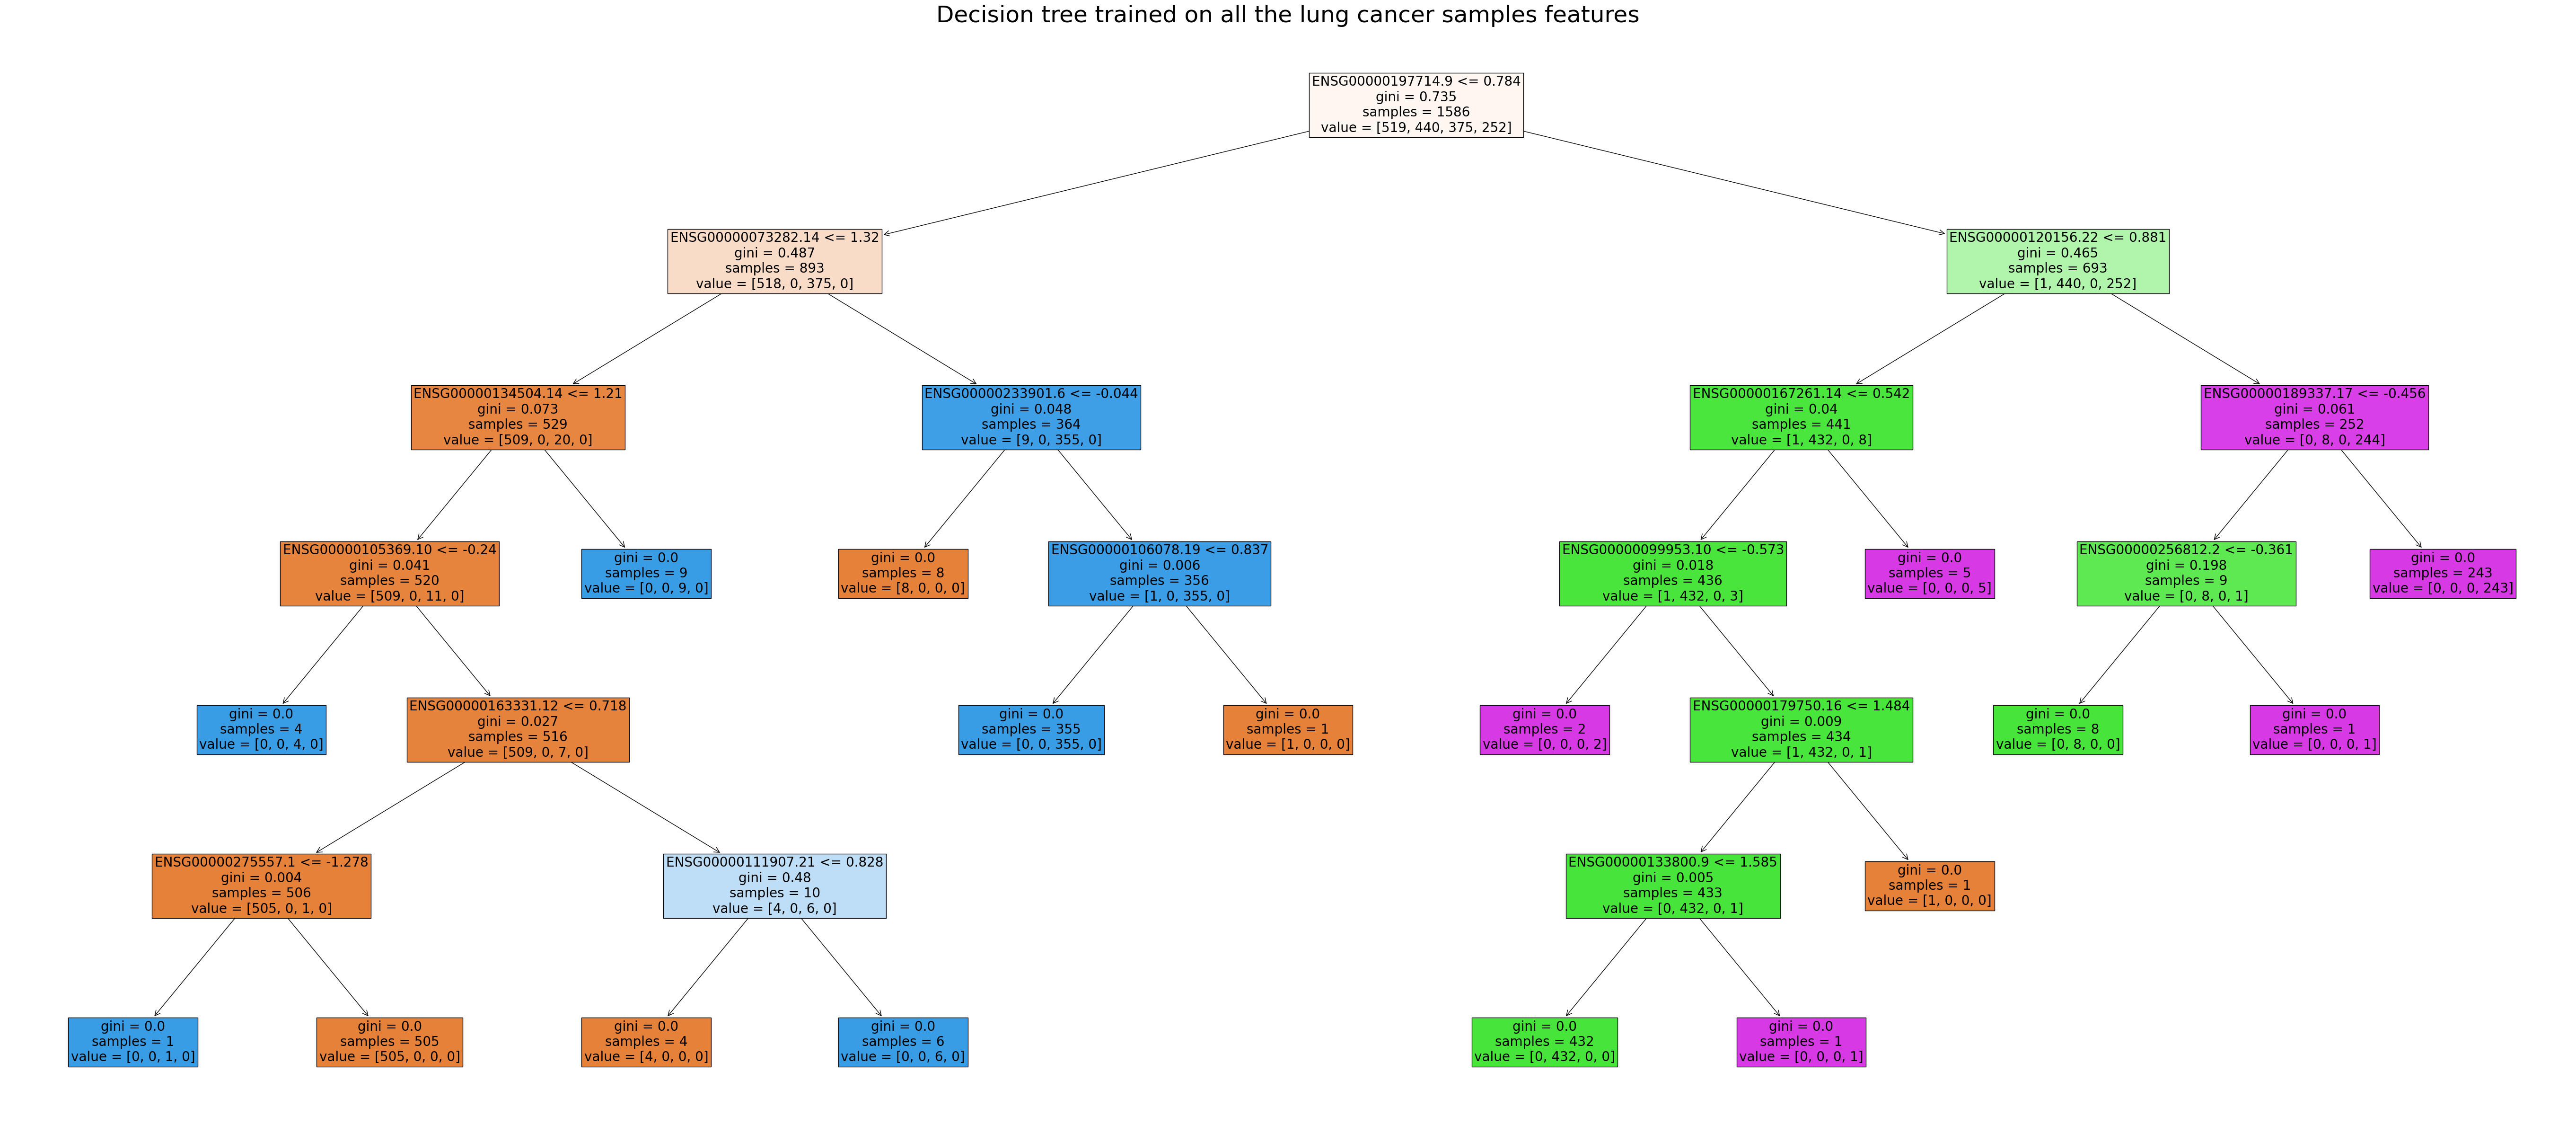

In [6]:
dt_viz = DecisionTreeClassifier(random_state = 43)
dt_viz.fit(X_train, y_train)

gene_ids = t_df.columns.tolist()

plt.figure(figsize = (70, 30))
plot_tree(dt_viz, filled = True, fontsize = 20, feature_names = gene_ids, class_names = None)
plt.title("Decision tree trained on all the lung cancer samples features", fontsize = 35)

We can appreciate how the tree is fully generated, until all nodes reach the maximum purity (gini = 0). Despite all the nodes plotted, there's only 4 classes (that are our 4 clusters of samples). This is indicated with node colors, that represent its majority class of samples. So the four classes are orange, green, blue and pink in the tree plot.
The most important genes in the tree plot, are the ones at depth 1 and 2, as they are the features by which the four majority classes can be defined. This genes are:
   - ENSG00000197714: Codifies for the Zinc Finger protein 460, that may be involved in transcriptional regulation.
   - ENSG00000073282: Codifies for the Tumor Protein 63, and presents nuclear expression in several tissues including squamous and respiratory epithelia and myoepithelial cells, acting acts as a sequence specific DNA binding transcriptional activator or repressor. And plays a role in the regulation of epithelial morphogenesis.
   - ENSG00000120156: Codifies for Angiopoietin-1 receptor, a tyrosine-protein kinase that acts as cell-surface receptor for ANGPT1, ANGPT2 and ANGPT4 and regulates angiogenesis, endothelial cell survival, proliferation, migration, adhesion and cell spreading.

# Results of the classification

Finally, to check the classifier performance the accuracy of predictions will be calculated and ROC (Receiver Operating Characteristic) curves for the 4 classes will be plotted.
“A receiver operating characteristic (ROC), or simply ROC curve, is a graphical plot which illustrates the performance of a binary classifier system as its discrimination threshold is varied. It is created by plotting the fraction of true positives out of the positives (TPR = true positive rate) vs. the fraction of false positives out of the negatives (FPR = false positive rate), at various threshold settings. TPR is also known as sensitivity, and FPR is one minus the specificity or true negative rate.”

Accuracy: 0.99


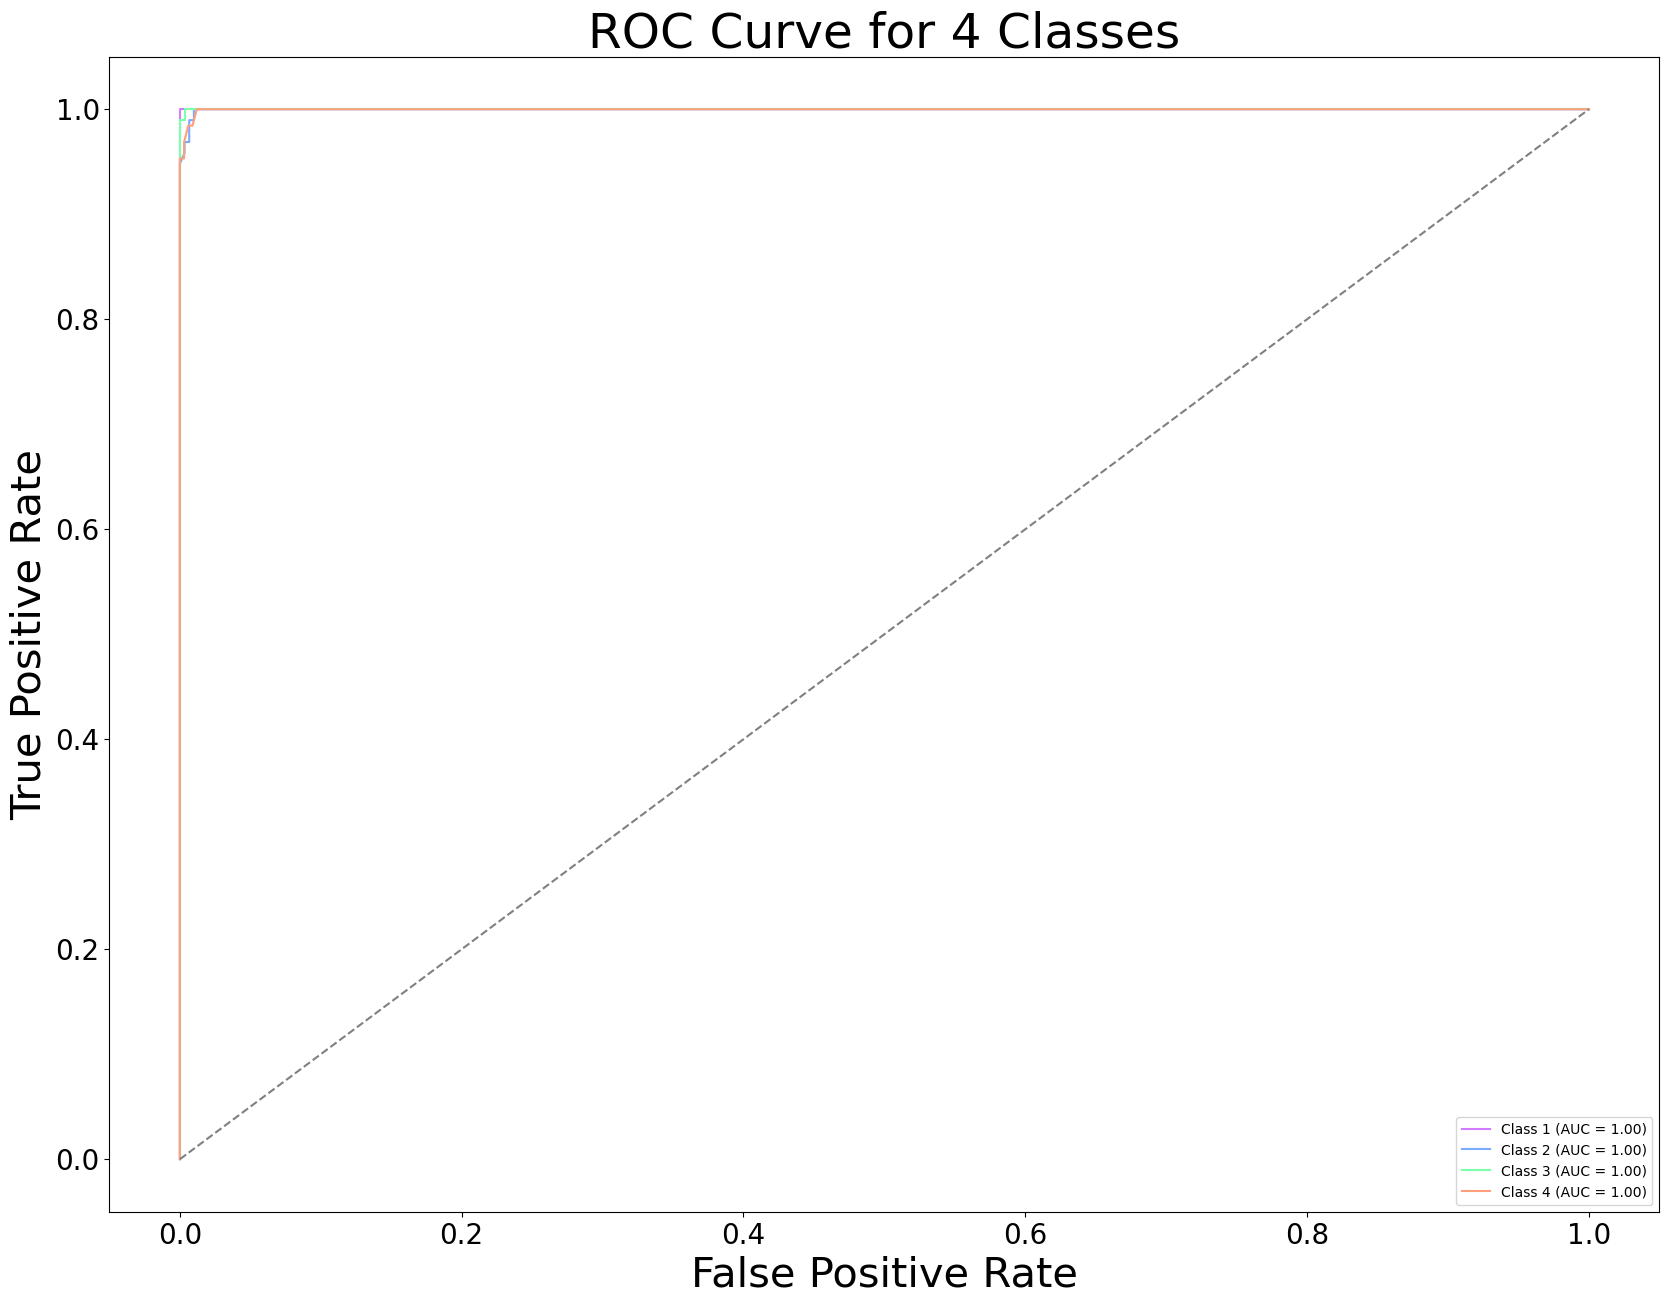

In [7]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

y_test_bin = label_binarize(y_test, classes = [1, 2, 3, 4])
fpr = dict()
tpr = dict()
roc_auc = dict()
cols = ['#D27BFF', '#7BAAFF', '#7BFFAA', '#FF9E7B']
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize = (20, 15))
for i in range(4):
    plt.plot(fpr[i], tpr[i], label = f'Class {i+1} (AUC = {roc_auc[i]:.2f})', color = cols[i])

plt.plot([0, 1], [0, 1], color = 'gray', linestyle = '--')
plt.xlabel('False Positive Rate', fontsize = 30)
plt.ylabel('True Positive Rate', fontsize = 30)
plt.title('ROC Curve for 4 Classes', fontsize = 35)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(loc = 'best')
plt.show()

# Further analysis

For further analysis of our classification, we can inspect how accuracy varies when using a different amount of genes and identifying with how many genes we reach maximum value of performance. 

For that we will make a loop in wich the classifier is trained with the amount of genes we will decide in **n_genes**, to then predict the class of the test dataset.

In [8]:
last = 0
num = 0
n_genes = []

while last < 200:
    if last < 30:
        num = num + 1
    elif last < 50:
        num = num + 5
    elif last < 100:
        num = num + 10
    else:
        n_genes.append(200)
        last = 200
        continue

    n_genes.append(num)
    last = n_genes[-1]

As decision tree classifyer only  construct one tree, we will use its feature importances to choose the genes easly.

In [9]:
gene_importance_dict = {gene_ids[i]: dt_viz.feature_importances_[i] for i in range(len(gene_ids))}
s_genes = pd.DataFrame(sorted(gene_importance_dict.items(), key=lambda x: x[1], reverse=True))
s_genes.index = s_genes[0]

In [10]:
result = []
for n in n_genes:
    data = df.loc[s_genes.iloc[:n].index]
    t_data = data.transpose()
    X = t_data.to_numpy()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)
    clf = RandomForestClassifier(random_state=43)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    result.append(accuracy)
    
df_final = pd.DataFrame(result,index = n_genes)

Maximum reached accuracy is 0.9949622166246851 with 15 genes


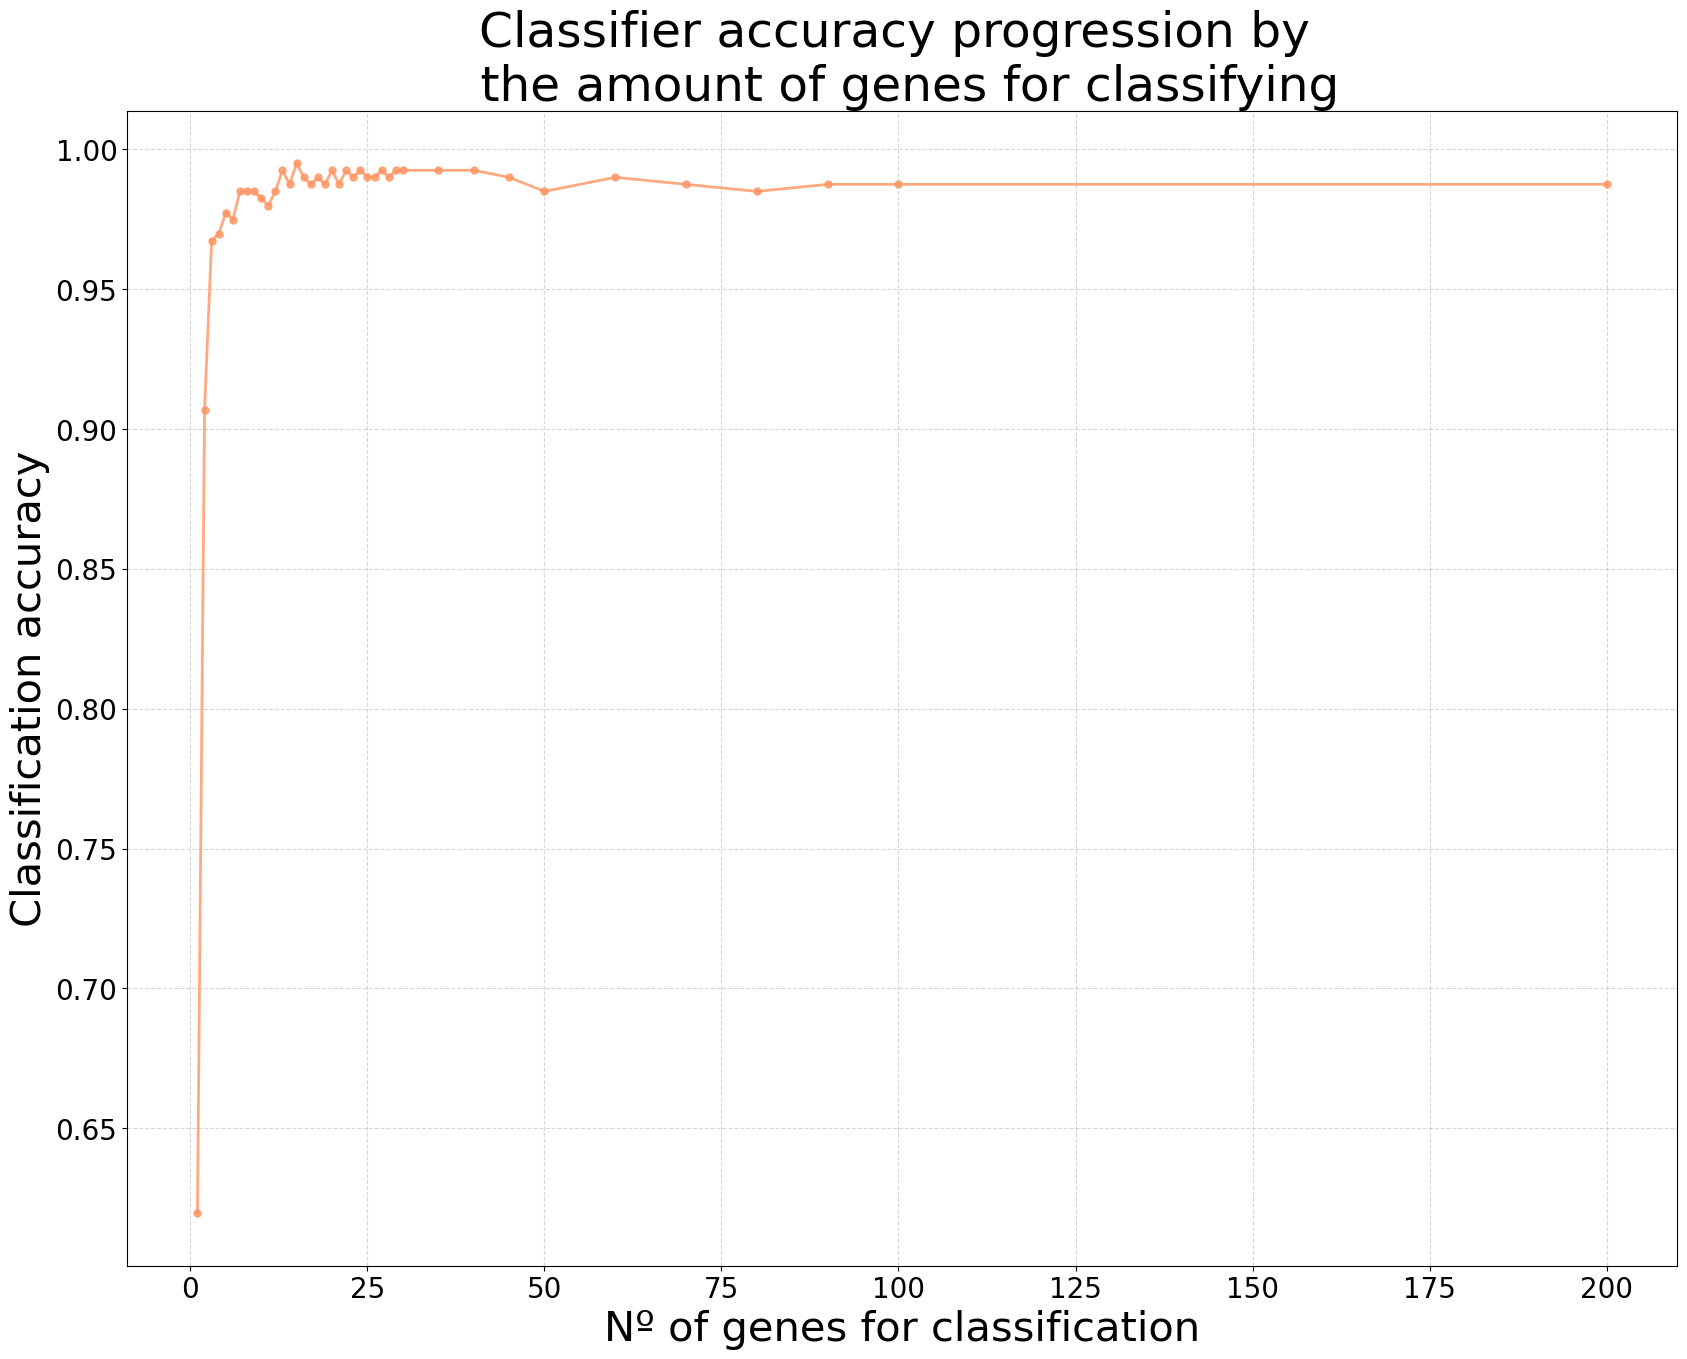

In [11]:
plt.figure(figsize=(20, 15))
plt.plot(n_genes, result, marker='o', markersize=5, color='#FF9462', linestyle='-', linewidth=2, alpha=.8)
plt.xlabel('Nº of genes for classification', fontsize = 30)
plt.ylabel('Classification accuracy', fontsize = 30)
plt.title('Classifier accuracy progression by \n the amount of genes for classifying', fontsize = 35)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True, linestyle="--", alpha=0.5)

print("Maximum reached accuracy is", max(result), "with", n_genes[result.index(max(result))], 'genes')